In [133]:
import jax.numpy as jnp
import jax.scipy
import numpy as np
import numpyro
import numpyro.distributions as dist

from jax import random, vmap
from numpyro import handlers

import matplotlib.pyplot as plt

In [218]:
%matplotlib inline

plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,  # higher resolution output.
})

In [188]:
SEEDS = [random.PRNGKey(i) for i in range(5)]

In [189]:
SIZES = [0, 2, 4, 6, 8, 10, 12, 14, 18]

In [190]:
def true_model(size):
    if size == 0:
        numpyro.deterministic("obs", jnp.array([]))
        return
    with numpyro.plate("data", size):
        # choice = numpyro.sample("choice", dist.DiscreteUniform())
        # Scale to +-1
        # numpyro.deterministic("obs", 2*choice - 1)
        numpyro.deterministic("obs", jnp.array([1, -1] * (size // 2) + ([] if size % 2 == 0 else [1])))

In [192]:
datas = [
    (seed, handlers.trace(handlers.seed(true_model, seed)).get_trace(size=size)['obs']['value'])
    for size in SIZES
    for seed in SEEDS
]

In [193]:
def model(obs, sigma_obs=0.5):
    size = jnp.shape(obs)[0] if obs is not None else 1
    mu = numpyro.sample("mu", dist.Normal(scale=1/3))
    with numpyro.plate("data", size):
        numpyro.sample("obs", dist.Normal(mu, sigma_obs), obs=obs)

In [194]:
# Prior KL from true distr
def get_prior_kl(seed):
    def sample_prior(rng_key):
        return handlers.trace(handlers.seed(model, rng_key)).get_trace(obs=None)['obs']['value']
    prior_samples = dict(mu=vmap(sample_prior)(random.split(seed, 400)).squeeze())
    logp_plus_one = numpyro.infer.log_likelihood(model, prior_samples, obs=np.array([1.]))
    logp_plus_one = jax.scipy.special.logsumexp(logp_plus_one['obs']) - jnp.log(prior_samples['mu'].shape[0])
    logp_neg_one = numpyro.infer.log_likelihood(model, prior_samples, obs=np.array([-1.]))
    logp_neg_one = jax.scipy.special.logsumexp(logp_neg_one['obs']) - jnp.log(prior_samples['mu'].shape[0])
    prior_kl = np.log(0.5) - 0.5 * (logp_plus_one + logp_neg_one)
    return prior_kl

In [195]:
# Asymptotic posterior KL with collapsed mu=0
asymptotic_posterior_samples = dict(mu=jnp.array([0.]))
logp_plus_one = numpyro.infer.log_likelihood(model, asymptotic_posterior_samples, obs=np.array([1.]))
logp_plus_one = jax.scipy.special.logsumexp(logp_plus_one['obs']) - jnp.log(asymptotic_posterior_samples['mu'].shape[0])
logp_neg_one = numpyro.infer.log_likelihood(model, asymptotic_posterior_samples, obs=np.array([-1.]))
logp_neg_one = jax.scipy.special.logsumexp(logp_neg_one['obs']) - jnp.log(asymptotic_posterior_samples['mu'].shape[0])
asymptotic_posterior_kl = np.log(0.5) - 0.5 * (logp_plus_one + logp_neg_one)
asymptotic_posterior_kl

DeviceArray(1.5326443, dtype=float32)

In [200]:
import collections
kls = collections.defaultdict(lambda: [])

In [201]:
for seed, data in datas:
    size = jnp.shape(data)[0] if data is not None else 0
    print(f"size: {size}")
    if size == 0:
        kl = get_prior_kl(seed)
        print(f"kl = {kl:.4f}")
        kls[size].append(kl)
        continue
    mcmc = numpyro.infer.MCMC(
        sampler=numpyro.infer.NUTS(model),
        num_warmup=400,
        num_samples=600,
    )
    mcmc.run(seed, obs=data)
    mcmc.print_summary()
    logp_plus_one = numpyro.infer.log_likelihood(model, mcmc.get_samples(), obs=np.array([1.]))
    logp_plus_one = jax.scipy.special.logsumexp(logp_plus_one['obs']) - jnp.log(mcmc.num_samples)
    logp_neg_one = numpyro.infer.log_likelihood(model, mcmc.get_samples(), obs=np.array([-1.]))
    logp_neg_one = jax.scipy.special.logsumexp(logp_neg_one['obs']) - jnp.log(mcmc.num_samples)
    kl = np.log(0.5) - 0.5 * (logp_plus_one + logp_neg_one)
    print(f"kl = {kl:.4f}")
    kls[size].append(kl)

size: 0
kl = 0.8239
size: 0
kl = 0.7579
size: 0
kl = 0.7934
size: 0
kl = 0.7869
size: 0
kl = 0.8142
size: 2


sample: 100%|██████████| 1000/1000 [00:10<00:00, 99.70it/s, 1 steps of size 1.06e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.03      0.23      0.02     -0.30      0.44    218.55      1.00

Number of divergences: 0
kl = 1.2872
size: 2


sample: 100%|██████████| 1000/1000 [00:14<00:00, 69.00it/s, 1 steps of size 9.52e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.03      0.23     -0.03     -0.43      0.31    237.40      1.00

Number of divergences: 0
kl = 1.2725
size: 2


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.34it/s, 3 steps of size 1.25e+00. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.00      0.25     -0.01     -0.38      0.41    163.57      1.00

Number of divergences: 0
kl = 1.2470
size: 2


sample: 100%|██████████| 1000/1000 [00:07<00:00, 142.31it/s, 3 steps of size 9.39e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.23     -0.03     -0.41      0.36    247.34      1.00

Number of divergences: 0
kl = 1.2701
size: 2


sample: 100%|██████████| 1000/1000 [00:05<00:00, 179.25it/s, 3 steps of size 1.04e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.21     -0.01     -0.36      0.30    254.34      1.00

Number of divergences: 0
kl = 1.3080
size: 4


sample: 100%|██████████| 1000/1000 [00:07<00:00, 128.81it/s, 1 steps of size 1.30e+00. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.19      0.02     -0.28      0.34    212.93      1.00

Number of divergences: 0
kl = 1.3411
size: 4


sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.44it/s, 3 steps of size 8.48e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.03      0.20     -0.03     -0.35      0.28    252.39      1.00

Number of divergences: 0
kl = 1.3359
size: 4


sample: 100%|██████████| 1000/1000 [00:05<00:00, 199.24it/s, 3 steps of size 1.26e+00. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.20     -0.01     -0.30      0.34    132.22      1.00

Number of divergences: 0
kl = 1.3266
size: 4


sample: 100%|██████████| 1000/1000 [00:05<00:00, 193.29it/s, 3 steps of size 9.83e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.19     -0.02     -0.30      0.31    215.93      1.00

Number of divergences: 0
kl = 1.3478
size: 4


sample: 100%|██████████| 1000/1000 [00:04<00:00, 219.33it/s, 1 steps of size 1.14e+00. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.18     -0.00     -0.30      0.25    226.91      1.00

Number of divergences: 0
kl = 1.3674
size: 6


sample: 100%|██████████| 1000/1000 [00:04<00:00, 237.34it/s, 1 steps of size 1.06e+00. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.16      0.01     -0.27      0.28    285.01      1.00

Number of divergences: 0
kl = 1.3957
size: 6


sample: 100%|██████████| 1000/1000 [00:04<00:00, 218.69it/s, 1 steps of size 9.77e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.17     -0.02     -0.30      0.22    240.15      1.00

Number of divergences: 0
kl = 1.3830
size: 6


sample: 100%|██████████| 1000/1000 [00:04<00:00, 246.14it/s, 1 steps of size 1.29e+00. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.17     -0.02     -0.25      0.30    198.22      1.00

Number of divergences: 0
kl = 1.3771
size: 6


sample: 100%|██████████| 1000/1000 [00:03<00:00, 255.36it/s, 3 steps of size 8.93e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.18     -0.01     -0.30      0.28    235.73      1.00

Number of divergences: 0
kl = 1.3714
size: 6


sample: 100%|██████████| 1000/1000 [00:05<00:00, 187.19it/s, 3 steps of size 1.01e+00. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.16     -0.01     -0.25      0.24    249.87      1.00

Number of divergences: 0
kl = 1.4000
size: 8


sample: 100%|██████████| 1000/1000 [00:05<00:00, 194.61it/s, 1 steps of size 1.10e+00. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.14      0.01     -0.22      0.27    276.14      1.00

Number of divergences: 0
kl = 1.4188
size: 8


sample: 100%|██████████| 1000/1000 [00:16<00:00, 60.02it/s, 3 steps of size 8.21e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.15     -0.02     -0.27      0.22    244.01      1.00

Number of divergences: 0
kl = 1.4052
size: 8


sample: 100%|██████████| 1000/1000 [00:05<00:00, 199.32it/s, 3 steps of size 1.29e+00. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.00      0.16     -0.01     -0.25      0.26    149.98      1.00

Number of divergences: 0
kl = 1.3990
size: 8


sample: 100%|██████████| 1000/1000 [00:04<00:00, 228.28it/s, 3 steps of size 7.98e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.15     -0.01     -0.25      0.25    235.34      1.00

Number of divergences: 0
kl = 1.4046
size: 8


sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.46it/s, 1 steps of size 1.09e+00. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.14     -0.01     -0.24      0.21    257.56      1.00

Number of divergences: 0
kl = 1.4193
size: 10


sample: 100%|██████████| 1000/1000 [00:04<00:00, 213.32it/s, 1 steps of size 1.20e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.02      0.14      0.02     -0.17      0.27    225.97      1.00

Number of divergences: 0
kl = 1.4326
size: 10


sample: 100%|██████████| 1000/1000 [00:05<00:00, 187.62it/s, 1 steps of size 8.59e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.14     -0.02     -0.27      0.18    208.78      1.00

Number of divergences: 0
kl = 1.4202
size: 10


sample: 100%|██████████| 1000/1000 [00:05<00:00, 192.84it/s, 3 steps of size 1.31e+00. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.14     -0.01     -0.21      0.24    188.34      1.00

Number of divergences: 0
kl = 1.4225
size: 10


sample: 100%|██████████| 1000/1000 [00:03<00:00, 274.39it/s, 3 steps of size 8.76e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.14     -0.02     -0.24      0.22    241.27      1.00

Number of divergences: 0
kl = 1.4245
size: 10


sample: 100%|██████████| 1000/1000 [00:03<00:00, 274.78it/s, 1 steps of size 1.15e+00. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.00      0.13      0.00     -0.22      0.19    266.16      1.00

Number of divergences: 0
kl = 1.4391
size: 12


sample: 100%|██████████| 1000/1000 [00:05<00:00, 190.49it/s, 1 steps of size 1.18e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.13      0.02     -0.16      0.25    206.62      1.00

Number of divergences: 0
kl = 1.4453
size: 12


sample: 100%|██████████| 1000/1000 [00:04<00:00, 204.41it/s, 1 steps of size 9.30e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.13     -0.02     -0.25      0.17    213.57      1.00

Number of divergences: 0
kl = 1.4368
size: 12


sample: 100%|██████████| 1000/1000 [00:04<00:00, 229.67it/s, 3 steps of size 1.13e+00. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.13     -0.01     -0.20      0.22    140.24      1.00

Number of divergences: 0
kl = 1.4347
size: 12


sample: 100%|██████████| 1000/1000 [00:03<00:00, 269.44it/s, 3 steps of size 8.66e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.14     -0.01     -0.22      0.22    253.94      1.00

Number of divergences: 0
kl = 1.4310
size: 12


sample: 100%|██████████| 1000/1000 [00:03<00:00, 268.12it/s, 3 steps of size 9.70e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.12     -0.00     -0.20      0.18    256.64      1.00

Number of divergences: 0
kl = 1.4523
size: 14


sample: 100%|██████████| 1000/1000 [00:04<00:00, 222.28it/s, 1 steps of size 1.02e+00. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.12      0.01     -0.17      0.21    262.64      1.00

Number of divergences: 0
kl = 1.4584
size: 14


sample: 100%|██████████| 1000/1000 [00:05<00:00, 178.50it/s, 1 steps of size 1.01e+00. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.02      0.12     -0.02     -0.22      0.16    240.71      1.00

Number of divergences: 0
kl = 1.4521
size: 14


sample: 100%|██████████| 1000/1000 [00:04<00:00, 201.53it/s, 3 steps of size 1.20e+00. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.12     -0.01     -0.18      0.21    157.31      1.00

Number of divergences: 0
kl = 1.4469
size: 14


sample: 100%|██████████| 1000/1000 [00:04<00:00, 248.57it/s, 3 steps of size 9.05e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.12     -0.01     -0.22      0.17    239.14      1.00

Number of divergences: 0
kl = 1.4510
size: 14


sample: 100%|██████████| 1000/1000 [00:04<00:00, 208.10it/s, 3 steps of size 1.11e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.11     -0.00     -0.19      0.17    213.35      1.00

Number of divergences: 0
kl = 1.4605
size: 18


sample: 100%|██████████| 1000/1000 [00:03<00:00, 255.42it/s, 1 steps of size 1.25e+00. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.11      0.02     -0.15      0.19    199.65      1.00

Number of divergences: 0
kl = 1.4648
size: 18


sample: 100%|██████████| 1000/1000 [00:04<00:00, 232.43it/s, 3 steps of size 1.02e+00. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.11     -0.00     -0.18      0.19    234.33      1.00

Number of divergences: 0
kl = 1.4619
size: 18


sample: 100%|██████████| 1000/1000 [00:06<00:00, 160.90it/s, 3 steps of size 1.19e+00. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.11     -0.01     -0.17      0.18    142.08      1.00

Number of divergences: 0
kl = 1.4616
size: 18


sample: 100%|██████████| 1000/1000 [00:04<00:00, 206.61it/s, 3 steps of size 8.88e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.11     -0.01     -0.19      0.18    229.55      1.00

Number of divergences: 0
kl = 1.4599
size: 18


sample: 100%|██████████| 1000/1000 [00:04<00:00, 209.51it/s, 3 steps of size 9.11e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.10     -0.00     -0.16      0.15    266.81      1.00

Number of divergences: 0
kl = 1.4766


In [203]:
kls = {size: jnp.array(values) for size, values in kls.items()}

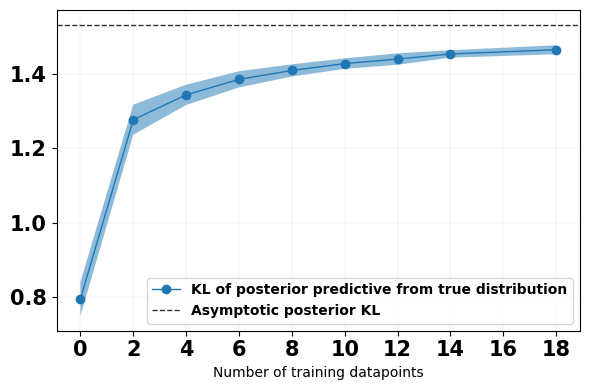

In [225]:
fig, ax = plt.subplots(figsize=(6,4))
kl_means = np.array([values.mean() for values in kls.values()])
kl_stds = np.array([values.std() for values in  kls.values()])
ax.plot(kls.keys(), kl_means, 'o-', label="KL of posterior predictive from true distribution")
ax.fill_between(SIZES, kl_means - 2*kl_stds, kl_means + 2*kl_stds, alpha=0.5)
ax.set_xticks(ticks=range(0, 20, 2), labels=range(0, 20, 2))
ax.axhline(y=asymptotic_posterior_kl, linestyle='--', label="Asymptotic posterior KL", alpha=0.8)
ax.set_xlabel("Number of training datapoints")
ax.legend()
fig.tight_layout()
fig.savefig("figs/classical_misspec.pdf")